### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales - 2019-2 </h1>

<H3 align='center'> Tarea 2  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en pandas y numpy, preprocesamientos
* Recurrent Neural Networks 
* LSTM, GRU
* Autoencoders
* GAN
 


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*).
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos), se penalizará fuertemente ausencia de comentarios, explicaciones de gráficos, _etc_. Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_, al correo electrónico del ayudante (<alvaro.valderrama.13@sansano.usm.cl>), en copia al profesor (<cvalle@inf.utfsm.cl>).   Especificar el siguiente asunto: [INF-395/477-2019 Tarea 2]. Invitar como colaborador al usuario de github "avalderr" para poder acceder al repositorio en caso de ser privado.
* Fecha de entrega y presentaciones: 21 de Febrero 2020 (Fase I). Hora límite de entrega: 23:59. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail igualmente.  

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

* 1 - Redes Recurrentes en Texto
* 2 - Autoencoders en Fashion MNIST    
* 3 - GAN para MNIST.

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con *comentarios* en celdas _Markdown_, con los comentarios de la pregunta y con cualquier analisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. *No respondan las preguntas en comentarios en el código*.
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará tanto la elección en si. En cambio la argumentación detrás de la elección será lo más ponderado.
Si algun modelo se demora demasiado en correr en su maquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, incluso con la opción de aceleración con GPU (particularmente útil para los modelos más grandes), esto puede ser relevante para las maquinas más lentas al momento de realizar exploraciones con _K-folds_ o las redes más grandes. Existe también la posibilidad de utilizar _Google Cloud Plataform_, donde tienen 300 dolares de prueba por un año y pueden comprar tiempo de procesamiento en maquinas aceleradas con GPU; maquinas ya configuradas para _deep leraning_ pueden encontrarse en el _Marketplace_.

# 1 - Redes Recurrentes en texto

El analisis de texto y en general de lenguaje natural es una de las tareas desafiantes que los avances tanto del machine learning como de redes neuronales han logrado potenciar el los último años. La naturaleza inherentemente secuencial del texto y sus características similares a variables categóricas han inspirado muchos avances interesantes en el area. Para esta primera aproximación a procesamiento de secuencias, y en particular de texto, utilizaremos un dataset relativamente estandar, de texto anotado con categorias de entidades. Este dataset se encuentra disponible en el siguiente link https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus. 

Durante esta pregunta realizaremos dos tareas distintas, la de predicción del _tag_ para cada palabra de la secuencia (_many to many_) y la de predicción del siguiente caracter (_many to one_). 


#### 1.a El dataset

Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cual es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario? De un ejemplo en caso contrario). 

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

Solo nos quedaremos con `word` y `lemma` de las variables regresoras, guardando `sentence_idx` para poder reconstruir las frases como unidad básica con la que trabajaremos. ¿Qué diferencia hay entre la palabra y su lemma? De ejemplos donde la diferencia sea significativa y explique en qué circunstancias preferiría una sobra la otra. 

Para la primera parte de estas preguntas, preferiremos los lemas pues buscaremos predecir el `tag` de la palabra.

In [4]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

# check if dataset exist
!ls

sample_data


In [0]:
!mkdir /root/.kaggle
!echo '{"username":"sebastingallardo","key":"df9d642f8dce03217fe5b41f25881f75"}' > /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 53% 14.0M/26.4M [00:00<00:00, 146MB/s]
100% 26.4M/26.4M [00:00<00:00, 169MB/s]


In [0]:
!unzip -q 'entity-annotated-corpus.zip'

In [8]:
import os
import glob
print(os.getcwd())
data_path = os.path.join(os.getcwd())
print(os.listdir(data_path))

/content
['.config', 'entity-annotated-corpus.zip', 'ner.csv', 'ner_dataset.csv', 'sample_data']


In [9]:
import pandas as pd
df = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)
df = df.dropna()[['lemma','tag','word','sentence_idx']]

Skipping line 281837: Expected 25 fields in line 281837, saw 34


In [0]:
print(df)

            lemma tag           word  sentence_idx
0        thousand   O      Thousands           1.0
1              of   O             of           1.0
2        demonstr   O  demonstrators           1.0
3            have   O           have           1.0
4           march   O        marched           1.0
...           ...  ..            ...           ...
1050790      they   O           they       47959.0
1050791   respond   O      responded       47959.0
1050792        to   O             to       47959.0
1050793       the   O            the       47959.0
1050794    attack   O         attack       47959.0

[1050794 rows x 4 columns]


#### 1.b Preprocesamiento

Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numericos. Esto pueden realizarlo con alguna de las utilidades de `keras` o `sklearn`, sin embargo en el código siguiente se propone un metodo solo usando python y `pandas`. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante. 

Complete y explique que realiza cada linea del código.

In [0]:
import numpy as np

lemma_to_code = {lemma:code+1 for code, lemma in enumerate(df.lemma.unique())}
tag_to_code = {tag:code+1 for code, tag in enumerate(df.tag.unique())}
n_lemmas = len(lemma_to_code)

df['lemma'] = df.lemma.apply(lambda x: lemma_to_code[x])
df['tag'] = df.tag.apply(lambda x: tag_to_code[x])

dff = df.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray)

In [11]:
print(tag_to_code)
tag_to_code["PAD"] = 0
n_tags = len(tag_to_code)
print(n_tags)

{'O': 1, 'B-geo': 2, 'B-gpe': 3, 'B-per': 4, 'I-geo': 5, 'B-org': 6, 'I-org': 7, 'B-tim': 8, 'B-art': 9, 'I-art': 10, 'I-per': 11, 'I-gpe': 12, 'I-tim': 13, 'B-nat': 14, 'B-eve': 15, 'I-eve': 16, 'I-nat': 17}
18


#### 1.c Padding

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden que problemas podría traer? ¿Estan las clases repartidas de manera equitativa?

En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar _padding_. El _padding_ debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función `keras.preprocessing.sequence.pad_sequences` o escribir sus propios códigos. Elija un valor de `maxlen` que le parezca adecuado.

¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

In [0]:
print(dff.shape)
print(dff)

(35177, 2)
                                                          lemma                                                tag
sentence_idx                                                                                                      
1.0           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ...
2.0           [23, 2, 24, 25, 12, 10, 26, 27, 10, 9, 28, 29,...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3.0           [42, 5, 19, 10, 43, 2, 44, 8, 45, 46, 12, 47, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, ...
4.0           [49, 50, 10, 37, 2, 51, 52, 53, 54, 55, 56, 57...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
5.0           [10, 9, 60, 61, 10, 62, 2, 10, 63, 64, 2, 65, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, ...
...                                                         ...                                                ...
47955.0       [1261, 489, 148, 308, 172, 716, 233, 484, 1360...  [3, 

(50,)
(70,)


{'boxes': [<matplotlib.lines.Line2D at 0x7f7daafd4e80>],
 'caps': [<matplotlib.lines.Line2D at 0x7f7dab086780>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7dab068198>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7dab086e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7dab0860f0>,
  <matplotlib.lines.Line2D at 0x7f7dab086438>]}

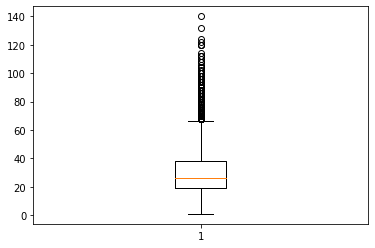

In [0]:
import matplotlib.pyplot as plt

print(dff.iloc[4].lemma.shape)
print(dff.iloc[42].lemma.shape)
largo = []
for i in range(dff.shape[0]):
  largo.append(dff.iloc[i].lemma.shape[0])

plt.boxplot(largo)

In [0]:
print(dff.iloc[423].tag.shape == dff.iloc[423].lemma.shape)
print(dff.iloc[34242].tag.shape == dff.iloc[34242].lemma.shape)
print(np.max(largo))

True
True
140


In [12]:
from keras.preprocessing.sequence import pad_sequences

max_len = 140
x = pad_sequences(dff.lemma.values,
                  maxlen=max_len,
                  padding='pre',
                  truncating='post'
)

y = pad_sequences(dff.tag.values,
                  maxlen=max_len,
                  padding='pre',
                  truncating='post'
)

print(y)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 2 5 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


#### 1.d Even more encodding and preprocessing

Para la primera tarea, buscaremos realizar la predicción del tag, la cual es una variable categórica. Por lo tanto, como ya sabemos de la tarea anterior, resulta conveniente tener los _targets_ en _one hot vector_. 

Además debemos separar ambos conjuntos (`x` e `y`) en los conjuntos de entrenamiento y validación. 

Realice esto con las herramientas y proporciones que estime convenientes. 

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

y = [to_categorical(i, num_classes=n_tags) for i in y]
x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.25, random_state=1)

y_tr = np.array(y_tr)
y_val = np.array(y_val)

print(x_tr.shape)
print(x_val.shape)

(26382, 140)
(8795, 140)


#### 1.e Primera red recurrente

Ahora entrenaremos una primera red recurrente LSTM. Explique la particularidad de estas redes y por qué podría comportarse bien para este tipo de problemas. 

La tarea de esta red será procesar la secuencia de _lemmas_ y predecir su _tag_. ¿Cuáles son las dimensiones de nuestro input y de nuestro output?

Considerando que si bien los _lemmas_ estan representados como enteros, esta representación no tiene ninguna relación con el "significado" de estos. Por eso, es recomendable utilizar otra representación que mejor extraiga la naturaleza "categorica" de estos, sin embargo por la cantidad de ejemplos que tenemos, no resultaría practico utilizar _one hot vector_, pues las dimensiones explotarían. Para esto, utilizaremos una primera capa que realiza una transformación entrenable entre el espacio discreto de la representación original y un _embedding_ en $\mathbb{R}^d$ donde $d$ corresponde a la dimensión de nuestro espacio de llegada.

Utilice un _embedding_ de dmensión 100, luego agregue una capa LSTM con 128 unidades y finalmente la capa densa de salida. Compile y entrene el modelo por al menos 10 epochs. Grafique el proceso de entrenamiento y evalue el desempeño final considerando alguna métrica relevante (F1 score, matriz de confusión, etc), considerando la repartición de clases que observó en la pregunta c.

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

ltsm = Sequential()

embedding_dim = 100
ltsm.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))

ltsm.add(LSTM(units=128,return_sequences=True)) # You can use CuDNNLSTM if you have a CUDA enabled GPU for faster performance

ltsm.add(Dense(n_tags, activation='softmax'))

ltsm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ltsm.summary()
history = ltsm.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=128)








Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 100)          2023900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 140, 128)          117248    
_________________________________________________________________
dense_1 (Dense)              (None, 140, 18)           2322      
Total params: 2,143,470
Trainable params: 2,143,470
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 26382 samples, validate on 8795 samples
Epoch 1/10





26382/26382 [==============================] - 52s 2ms/step - loss: 0.3903 - acc: 0.9281 - val_loss: 0.1607 - val_acc: 0.9673
Epoch 2/10
26382/26382 [==============================] - 43s 2ms/step - loss: 0.

Test loss: 0.03737807533258467
Test accuracy: 0.9892203361219544


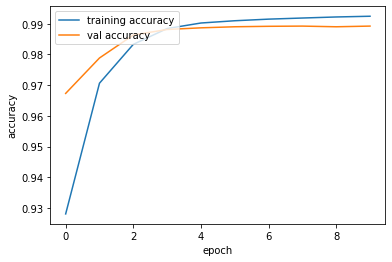

In [24]:
import matplotlib.pyplot as plt 

plt.plot(history.history["acc"],label="training accuracy")
plt.plot(history.history["val_acc"],label="val accuracy")
plt.legend(loc="upper left")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot
score = ltsm.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [25]:
!pip install seqeval
!pip install sklearn_crfsuite

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=87aaff66ce388d6e564434e64782d390839dfd79c3f9966890faf0a168c00da2
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 757kB 4.2MB/s 


In [27]:
idx2tag = {i: w for w, i in tag_to_code.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(list(idx2tag.values())[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = ltsm.predict(x_val, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_val)

8795/8795 [==============================] - 17s 2ms/step


In [28]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from  sklearn_crfsuite.metrics import flat_classification_report  

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 94.7%


In [29]:
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.91      0.80      0.85      5000
       B-eve       0.00      0.00      0.00        66
       B-geo       0.97      0.99      0.98    220977
       B-gpe       0.81      0.81      0.81      9380
       B-nat       0.79      0.57      0.66      1494
       B-org       0.79      0.66      0.72      1828
       B-per       0.90      0.91      0.91      4145
       B-tim       0.66      0.53      0.59      4104
       I-art       0.00      0.00      0.00       100
       I-eve       0.71      0.05      0.10        96
       I-geo       0.81      0.71      0.75      4058
       I-gpe       0.86      0.81      0.84      4134
       I-nat       0.00      0.00      0.00        83
       I-org       0.70      0.49      0.58      5020
       I-per       0.00      0.00      0.00        64
       I-tim       0.00      0.00      0.00        48
           O       1.00      1.00      1.00    970703

    accuracy              

#### 1.f Comparación con otras aproximaciones. 

Ahora entrenaremos dos redes más para comparar los desempeños de la red recurrente. Para esto entrenaremos una red convolucional 1-dimensional y una red densa. Discuta las diferencias entre ambas redes y la red recurrente, y cual cree a priori se adecua mejor a la naturaleza del problema. 

Defina y entrene luego las redes con la misma primera capa de encodding y las siguientes configuraciones:
* Convolucional: 2 capas conv1d con 128 filtros y kernel de tamaño 5
* Densa: 2 capas densas de 128 unidades

Compare los desempeños de las 3 redes en el problema su métrica preferida

In [78]:
from keras.layers import Conv1D, Embedding
from keras.models import Sequential
from keras.layers import Dense

conv = Sequential()

embedding_dim = 100
conv.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
conv.add(Conv1D(128, 5, activation='relu', padding='same'))
conv.add(Conv1D(128, 5, activation='relu', padding='same'))
conv.add(Dense(n_tags, activation="softmax"))

conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = conv.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=0, batch_size=128)
conv.summary()
history = conv.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=128)

Train on 26382 samples, validate on 8795 samples
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 140, 100)          2023900   
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 140, 128)          64128     
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 140, 128)          82048     
_________________________________________________________________
dense_13 (Dense)             (None, 140, 18)           2322      
Total params: 2,172,398
Trainable params: 2,172,398
Non-trainable params: 0
_________________________________________________________________
Train on 26382 samples, validate on 8795 samples
Epoch 1/10
26382/26382 [==============================] - 3s 116us/step - loss: 0.2401 - acc: 0.9675 - val_loss: 0.0683 - val_acc: 0.9792
Epoch

In [76]:
from keras.layers import Flatten

dense = Sequential()

embedding_dim = 100
dense.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
dense.add(Dense(128, activation='relu'))
dense.add(Dense(128, activation='relu'))
dense.add(Dense(n_tags, activation="softmax"))

dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = dense.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=0, batch_size=128)
dense.summary()
history = dense.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=128)


Train on 26382 samples, validate on 8795 samples
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 140, 100)          2023900   
_________________________________________________________________
dense_9 (Dense)              (None, 140, 128)          12928     
_________________________________________________________________
dense_10 (Dense)             (None, 140, 128)          16512     
_________________________________________________________________
dense_11 (Dense)             (None, 140, 18)           2322      
Total params: 2,055,662
Trainable params: 2,055,662
Non-trainable params: 0
_________________________________________________________________
Train on 26382 samples, validate on 8795 samples
Epoch 1/10
26382/26382 [==============================] - 2s 90us/step - loss: 0.4261 - acc: 0.9623 - val_loss: 0.0604 - val_acc: 0.9845
Epoch 

#### 1.g Red más profunda o bidireccional

Una pregunta natural que surge es saber que ocurre al aumentar la profundidad de la red, o por ejemplo porqué solo se recorre el _input_ en la dirección original. Considerando el tiempo acotado de este semestre, pueden elegir realizar una de las dos exploraciones solamente. 

* Profundidad: Entrene un par de redes con más capas LSTM y grafique como se comporta el desempeño a medida se aumenta la profundidad
* Bidireccional: Varie la cantidad de unidades (a lo menos 4 valores distintos) de la capa LSTM y compare con la red utilizando capas LSTM bidireccionales (como muestra el código). Comente sobre el número de parámetros en ambos casos.

In [0]:
from keras.layers import Bidirectional

model.add(Bidirectional(LSTM(# . . .  ) ) ) 

#### 1.h Dimensión del Embedding

Como podrán haber notado, gran parte de los parámetros entrenables se encuentran en el embedding. Elija una de las redes entrenadas anteriormente y varíe la dimensión del embedding en un conjunto de potencias de 2 que le parezca razonable (a lo menos 6 valores). Comente sus observaciones.

In [0]:
# Do it yourself 

#### 1.i Escribamos palabras - Datasest

Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un _Shakespeare_ en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado. 

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejormente el dataset, de cierta forma aumentando el número de datos. El _target_ en este caso será solo el caracter siguiente correspondiente a cada secuencia. 

En este item debe cargar el dataset, completando el código propuesto abajo. 

In [0]:
df_w = pd.read_csv(os.path.join("data","entity-annotated-corpus","ner.csv"), engine='python', error_bad_lines=False)

df_w = df_w.dropna()[['word']]

corpus = ' '.join(list(df_w.word.values)).lower()

sentence_length = 40
steps = 5

sentences = []
next_char = []
for i in range(0,len(corpus) - sentence_length - 1 , steps):
    sentences.append( # . . . )
    next_char.append( # . . . )

chars_to_code = {char:code for code, char in enumerate(set(corpus))}
code_to_chars = {code:char for char,code in chars_to_code.items()}

x = pd.np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])
# . . .
y = to_categorical(y)

#### 1.j Escribamos palabras - Red

Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalue el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como `callback` para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas. 

Una vez esté satisfecho de su red, hagala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

In [0]:
def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(char, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# . . . 

character.fit(x,y, epochs=35, callbacks=[print_text_callback])

# 2 - Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imagenes de articulos de vestimenta, el Fashion MNIST. 

### 2.a Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

In [0]:
from keras.datasets import fashion_mnist
(x_train,y_train),(x_val,y_val) = fashion_mnist.load_data()

import matplotlib.pyplot as plt

plt.imshow(# . . .)

### 2.b Posibilidades de preprocesamiento y pequeños análisis. 

¿Cuáles son los rangos de valores de `x`? ¿Por qué?

¿Las distintas clases de ejemplos están balanceadas?

¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

In [0]:
# . . . 
x_train_vector = x_train.reshape(-1,28*28)

### 2.c Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados, ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion? Grafique como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

In [0]:
from keras.layers import Dense
from keras.models import Sequential

autoencoder = Sequential()

autoencoder.add(Dense(32,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation= # . . . )) #decoder

autoencoder.compile(# . . .
    
autoencoder.fit(x_tr,x_tr,epochs=50,validation_data=(x_val,x_val) # . . .
    
                
plt.imshow(autoencoder.predict(x_val[i]).reshape(28,28),cmap='Greys')

### 2.d Sin escalar
Entrene nuevamente la misma estructura de red pero esta vez utilizando los datos originales (sin escalar). ¿Qué función de activación debe utilizar para la capa de salida? ¿Le parece sea una buena aproximación comparando con las caracteristicas de la red anterior? 

Compare los desempeños viendo las imagenes reconstruidas. 

De aquí en adelante prefiera la versión de los datos escaladas para consistencia. 

In [0]:
# do it yourself

### 2.e Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

In [0]:
# do it yourself

### 2.f Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. 

¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 


In [0]:
# do it yourself

### 2.g Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

In [0]:
autoencoder_conv.add(Deconvolution2D(64, 2, strides=2,activation='relu', padding='same'))
autoencoder_conv.add(Deconvolution2D(1, 2, strides=2,activation='sigmoid', padding='same'))

# . . .

### 2.h Transfer Learning y reducción de dimensionalidad

Como mencionamos inicialmente, una de las utilidades de los autoencoders corresponde a la no necesidad de tener etiquetas. En ese caso, podemos utilizar los autoencoders para extraer representaciones significativas de los ejemplos no etiquetados, y luego utilizar ese conocimiento para mejorar el desempeño de nuestros algoritmos. 

Para simular esta tarea supongamos que tenemos la misma base de datos original, sin embargo solo poseemos un pequeño porcentaje de las etiquetas del conjunto de entrenamiento, menos del $5\%$ (considere que si tuviera que etiquetar manualmente incluso solo un $5\%$ correspondería a 3000 imagenes por etiquetar!).

Seleccione un subconjunto de datos correspondiente a menos del $5\%$ de los datos y entrene un modelo predictivo para el problema de clasificación. Si bien la aproximación convolucional suele ser la mejor para este tipo de bases de datos, utilice arquitectura densa. 

Luego, utilizando el mejor autoencoder entrenado hasta ahora (o entrene uno nuevo si prefiere), utilize lo aprendido por la red sobre el conjunto de datos sin etiquetas para intentar aprender la relación suyaciente. Para esto, lo más fácil es primero preprocesar el conjunto `x` de entrenamiento, utilizando la sección de encoding de su autoencoder. Puede crear un nuevo modelo secuencial solo con las capas de encoding como se muestra en el código y luego usar el método `.predict` del modelo. Luego sobre estos datos preprocesados entrene un nuevo modelo predictivo fully connected. 

La otra opción sería crear un modelo cuya primeras capas correspondan a la sección de encoding del autoencoder y las últimas capas a su modelo denso, pero fijando el atributo `trainable` de las primeras capas como `False`, sin embargo esto resulta poco eficiente. 


Comente sus resultados basándose en métricas adecuadas. Comente igualmente sobre la dimensionalidad de las representaciones utilizadas por cada uno de los dos modelos entrenados en esta sección y el número de parametros _entrenables_ y totales del modelo (considerando el encoding). 

Considerando la dimensionalidad obtenida por el encoder, compare la calidad de la representación obtenida por el autoencoder frente a otras aproximaciones de reducción de dimensionalidad, como por ejemplo Principal Component Analysis (PCA). Para esto, transforme los datos de entrenamiento utilizando PCA con un número de componentes principales igual a la dimensión de la representación engendrada por su encoder. Compare el desempeño de un modelo determinado utilizando ambas representaciones. 

Comente sus resultados.

In [0]:
encoder = Sequential()

encoder.add(best_autoencoder.get_layer(index=0))

# . . . add as many as you need

encoder.predict( # . . .


    
    
from sklearn.decomposition import PCA

pca = PCA(n_components=d)

# . . . fit and transform


### 2.i Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy` o utilizar por ejemplo el `ImageDataGenerator` que utilizamos en la tarea anterior para generar imágenes similares con las cuales "sumar" ruido. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patron de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imagen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida. Pruebe igualmente entregarle a la red nuevas.

In [0]:
from numpy.random import # . . .

# . . .

from keras.preprocessing.image import ImageDataGenerator

### 2.j Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imagenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imagen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imagenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imagen resultante utilizando el decoder. ¿Qué observa? Muestre las imagenes obtenidas junto con otras imagenes de la misma categoría que la imagen que utilizó originalmente. Preube con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imagen obtenida al promediar las representaciones comprimidas de varias (o todas) las imagenes de una clase. Utilice el encoder para generar imagenes a partir de otros valores que se les ocurran y especule sobre el por qué la imagen obtenida se asimila o no a las imagenes del dataset. 

In [0]:
# do it yourself

# 3 - GAN para MNIST 

Probablemente uno de los desarrollos recientes del area de las redes neuronales más interesantes son las GAN, o _Generative Adversarial Networks_. Estas han deslumbrado al mundo los últimos años generando resultados inesperados, como los llamados _deep fakes_ (https://www.youtube.com/watch?v=dh-QM54RuAs), caras no no existentes generadas artificialmente, entre muchas otras aplicaciones de las cuales las más creativas y divertidas son ampliamente divulgadas. Estos resultados nos dan cuenta que estas redes cuando son implementadas correctamente tienen la habilidad de realizar tareas muy especificas logrando desempeños que en logran incluso en algunos casos engañar a observadores humanos.

<img src="https://pathmind.com/images/wiki/GANs.png" background="white">

Dependiendo del problema que uno quiera resolver las GAN no requieren datos etiquetados. Esto lo logran gracias a su estructura adversarial, es decir, donde simultaneamente se entrenan dos redes, una especializada en generar datos y otra red especializada en discriminar datos verdaderos de datos falsos, en su configuración más simple al menos. En esta parte de la tarea deberan generar una red de este tipo que genere dígitos que aparenten ser hechos a mano. Para esto utilizaremos las imagenes de entrenamiento del dataset MNIST que ya conocen.

A diferencia de otras preguntas, en esta deberán tener mayor iniciativa propia y solamente se presentará una estructura básica la cual ustedes deberán completar y ajustar para que el entrenamiento se realice bien. Además deberán:

* Graficar alguna medida del desempeño tanto del generador como del disciminador (por ejemplo f1-score, precision and recall o accuracy) a lo largo del entrenamiento. ¿Variaciones en esta medidas representan mejoras en nuestra red?
* Visualizar imagenes generadas por el generador a lo largo del entrenamiento y ver su evolución (idealmente graficar epocas representativas de etapas del entrenamiento)
* Explicar el comportamiento de la evolución de ambos desempeños y por qué no necesariamente esos valores representan que la red alcance su cometido
* Describir, teórica o práctiamente, que ocurriría si la red generadora no pudiera por algún motivo (divergencia en entrenamiento, excesivo _underfitting_, etc) generar imágenes razonables.
* Describir la contraparte de lo que ocurriría si la red discriminadora no pudiera aprender a diferenciar imagenes reales de ruido aleatorio.
* Una vez teniendo una red entrenada a completitud, muestre varias imagenes generadas. ¿Se logra obtener imagenes convincentes?
* Igualmente con la red entrenada, guarde el ruido aleatorio que origina dos números reconocibles distintos. ¿Qué ocurre si vemos las imagenes generadas por el generador al entregarle puntos distribuidos linealmente entre los dos puntos?
* Proponga o investigue como realizaría las siguientes tareas:
    * A partir de una base de datos de imagenes RGB, entrenar una GAN que genere imágenes a color convincentes a partir de imagenes en blanco y negro, es decir que deduzca el color a partir de imagenes en blanco y negro.
    * A partir de una base de datos de cuadros de paisajes reales y las fotos correspondientes al cuadro, entrenar una GAN que permita transformar fotografias a cuadros y viceversa (puede utilizar más de 2 redes)
    * Proponga un problema que les parezca interesante y una estructura de GAN que le permitiría resolverlo
    
Esta pregunta si bien es libre, debe ser redactada de manera ordenada. La recomendación es separar tanto el código como las respuestas en varios bloques, y enunciar nuevamente las preguntas o redactar sus respuestas de manera que no quede duda a qué pregunta en particular estan respondiendo. El código de abajo está incompleto y es solo una guía (de todas formas la estructura y entrenamiento de la red "funciona", aunque se recomienda prueben pequeños cambios), puede crear funciones, cambiar nombres e incluso las redes mismas como estimen conveniente, la intención es que se aproximen a la exploración que deberán hacer si alguna vez les toca resolver un problema real con ANN y luego reportar sus resultados. 

<!-- glhf -->

In [0]:
from keras.datasets import mnist

(x,_),(_,_) = mnist.load_data()
x = x.reshape((-1,28,28,1)).astype(np.float32)
x = x/255


generator_net = Sequential()

generator_net.add(Dense(7*7*256, input_dim=100))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(LeakyReLU())
generator_net.add(Reshape((7,7,256)))
generator_net.add(Dropout(dropout_prob))

generator_net.add(UpSampling2D())
generator_net.add(Conv2D(128, 5, padding='same'))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(LeakyReLU())

generator_net.add(UpSampling2D())
generator_net.add(Conv2D(64, 5, padding='same'))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(LeakyReLU())

generator_net.add(Conv2D(32, 5, padding='same'))
generator_net.add(BatchNormalization(momentum=0.9))
generator_net.add(LeakyReLU())

generator_net.add(Conv2D(1, 5, padding='same'))
generator_net.add(Activation('sigmoid'))


discriminator_net = Sequential()

discriminator_net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
discriminator_net.add(LeakyReLU())

discriminator_net.add(Conv2D(128, 5, strides=2, padding='same'))
discriminator_net.add(LeakyReLU())
discriminator_net.add(Dropout(dropout_prob))

discriminator_net.add(Conv2D(256, 5, strides=2, padding='same'))
discriminator_net.add(LeakyReLU())
discriminator_net.add(Dropout(dropout_prob))

discriminator_net.add(Conv2D(512, 5, strides=1, padding='same'))
discriminator_net.add(LeakyReLU())
discriminator_net.add(Dropout(dropout_prob))

discriminator_net.add(Flatten())
discriminator_net.add(Dense(1))
discriminator_net.add(Activation('sigmoid'))

optimizer_discriminator = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
discriminator = Sequential()
discriminator.add(discriminator_net)
discriminator.compile(loss='binary_crossentropy', optimizer = optimizer_discriminator, metrics=['accuracy'])

optimizer_gan = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
gan = Sequential()
gan.add(generator_net)
for layer in discriminator_net.layers:
    layer.trainable = False
gan.add(discriminator_net)
gan.compile(loss='binary_crossentropy', optimizer=optimizer_gan, metrics=['accuracy'])


for i in range(total_epochs):
    images_train = # select batch_size random images from x
    
    noise = # generate (batch_size,latent_dim) sized noise
    images_fake = generator_net.predict(noise)

    x_train = np.concatenate((images_train, images_fake))

    response_dis = discriminator.train_on_batch(x_train, y)
    response_gen = gan.train_on_batch(noise,y_gen)

    if i%save_results_every==0:
        # save accuracies and losses for plotting
        
        if i%plot_every==0:
            # plot random generated images and losses and accuracies